## Model: doubly constrained gravity (MSE)

commute ~ k*U*V*f(D), 
with U,V being fitted iteratively as per constraints: sum(U)=total population, sum(V)= total jobs

### preprocessing:

- spatial resolution: census tract level


- For income separated analysis, assume origin/destination population/jobs as the numbers corresponding to the individual income group in question.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.model_selection import StratifiedKFold
from ipfn import ipfn
# import pycombo
import sttn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import normalized_mutual_info_score as nmi
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
# import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
provider = OriginDestinationEmploymentDataProvider()

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance

%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]
# cities = [
#     ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
# ]

In [3]:
# get data for above cities - census tract level

allCity_dfs = []
job_column = 'S000'
comp_aggs={job_column: 'sum'}
for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    with_distance = add_distance(city_network).edges
    
    city_jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'}).reset_index()
    city_pop = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residence'}).reset_index()
    
    city_dist = with_distance.merge(city_jobs, on='destination')
    city_cum = city_dist.merge(city_pop, on='origin')
    
    # edge cases
#     city_cum.loc[city_cum.distance == 0, 'distance'] = 0.2
#     city_cum.loc[city_cum['SE01'] == 0, 'SE01'] = 0.1
#     city_cum.loc[city_cum['SE02'] == 0, 'SE02'] = 0.1
#     city_cum.loc[city_cum['SE03'] == 0, 'SE03'] = 0.1
    city_cum.rename(columns={'origin':'from', 'destination':'to'}, inplace=True)
    
    allCity_dfs.append(city_cum)

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


In [28]:
len(allCity_dfs)

1

In [48]:
# # get data for above cities - census tract level

# allCity_dfs = []
# job_column = 'S000'
# comp_aggs={job_column: 'sum'}
# for city, state, conties in cities:
#     state_network = provider.get_data(state=state, year=2018)
#     city_network = state_network.filter_nodes(state_network.node_labels.county.isin(conties))
    
#     with_distance = add_distance(city_network).edges_df
# #     with_weights = compute_weights(city_network, column)
    
#     city_jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'}).reset_index()
#     city_pop = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residence'}).reset_index()
    
#     city_dist = with_distance.merge(city_jobs, on='to')
#     city_cum = city_dist.merge(city_pop, on='from')
#     allCity_dfs.append(city_cum)

In [4]:
len(allCity_dfs)

12

In [171]:
# ny, la, ch = allCity_dfs[0], allCity_dfs[1], allCity_dfs[2]

# # update distance same o-d pair points with 0.2 miles
# ny.loc[ny.distance == 0, 'distance'] = 0.2
# la.loc[la.distance == 0, 'distance'] = 0.2
# ch.loc[ch.distance == 0, 'distance'] = 0.2

In [41]:
getbins(city)

,from,to,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,distance,S000jobs,S000residents,bin
129513,36005009800,36005001600,11,4,3,4,4.0,3.0,4.0,0,0,11,1.029180,1018,1871,"(0.132, 1.897]"
422280,36047022400,36047010400,1,1,0,0,1.0,0.1,0.1,0,1,0,1.584904,2397,1462,"(0.132, 1.897]"
764065,36081071702,36081071701,34,8,17,9,18.0,4.0,12.0,0,7,27,0.344354,5563,1949,"(0.132, 1.897]"
159496,36005034200,36005033400,1,0,1,0,0.1,0.1,1.0,0,0,1,1.755501,841,587,"(0.132, 1.897]"
422248,36047022400,36047011000,30,11,12,7,15.0,10.0,5.0,4,2,24,0.497277,1151,1462,"(0.132, 1.897]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325931,36085014606,36061024000,3,1,1,1,1.0,0.1,2.0,0,0,3,31.371839,2727,2277,"(25.193, 55.826]"
446598,36047032600,36005042400,1,1,0,0,0.1,1.0,0.1,0,0,1,36.687005,182,2255,"(25.193, 55.826]"
324950,36085012806,36081005800,1,0,0,1,0.1,0.1,1.0,0,0,1,25.354846,531,2075,"(25.193, 55.826]"
47219,36047004900,36005044902,1,1,0,0,0.1,1.0,0.1,1,0,0,25.851849,222,1184,"(25.193, 55.826]"


In [14]:
# function for bins
def getbins(df, nbins=20):
    
    df.loc[df.distance == 0, 'distance'] = 0.1
    
    df['bin'] = pd.qcut(df['distance'], q=nbins)
    df.sort_values(by='bin', inplace=True)
#     df.loc[df['SE01'] == 0, 'SE01'] = 0.1
#     df.loc[df['SE02'] == 0, 'SE02'] = 0.1
#     df.loc[df['SE03'] == 0, 'SE03'] = 0.1
    
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence'}, inplace=True)
    
    return df

# doubly constrained model
def constrained_model(data, separate_income=False):
    
#     y_target = ['S000']  # target = total commute if no income segregation
    y_target = ['S000']  # target = total commute if no income segregation
#     data.loc[data.distance == 0, 'distance'] = 0.2
#     origin = df.groupby(['origin']).agg({'S000':sum}).reset_index()
#     origin.columns = ['origin','S000residence']
#     destination = df.groupby(['destination']).agg({'S000':sum}).reset_index()
#     destination.columns = ['destination','S000jobs']
#     data = data.merge(origin,on=['origin'])
#     data = data.merge(destination,on=['destination'])
    
    if separate_income == True:
        
        y_target = ['SE01', 'SE02', 'SE03'] # target = individual income commute if income segregation
        
        origin = data.groupby(['from']).agg({'SE01':sum,'SE02':sum,'SE03':sum}).reset_index()
        origin.columns = ['from','SE01residence','SE02residence','SE03residence']
        destination = data.groupby(['to']).agg({'SE01':sum,'SE02':sum,'SE03':sum}).reset_index()
        destination.columns = ['to','SE01jobs','SE02jobs','SE03jobs']
        data = data.merge(origin,on=['from'])
        data = data.merge(destination,on=['to'])
    
    dataF = []
    dataUV = []
    
    for target in y_target:
#         print(target)
        allF = {}

        # estimate F for each bin
        for b in data['bin'].unique():

            subData = data[data['bin'] == b]
            
#             X = sm.add_constant(np.log(subData[target+'residence']) + np.log(subData[target+'jobs']))
            X = sm.add_constant(subData[target+'residence']*subData[target+'jobs'])
            y = subData[target]

            model_F = sm.OLS(y,X).fit()

            allF[b] = model_F.params[0]

        binF = pd.DataFrame.from_dict(allF, orient='index', columns={'F'}).reset_index()
        binF.rename(columns={'index':'bin'}, inplace=True)
        
        dataF.append(binF)
        
        allU = {}
        allU_arr = []

        # temporary dataframe with F
        dataStep1 = data.merge(binF, on='bin', how='left') 

        # estimate V(o) for each origin
        for o in data['from'].unique():

            subData = dataStep1[dataStep1['from'] == o]
            
            X = subData[target+'residence']*subData['F']
            y = subData[target] - subData[target+'jobs']
            

            X = sm.add_constant(X)
            model_U = sm.OLS(y,X).fit()

            allU[o] = model_U.params[0]
            allU_arr.append([model_U.params[0]]*len(subData))

        binU = pd.DataFrame.from_dict(allU, orient='index', columns={'V'}).reset_index()
        binU.rename(columns={'index':'from'}, inplace=True)

        # temporary dataframe with U
        dataStep2 = dataStep1.merge(binU, on='from', how='left') 
        # temp = dataStep2[['from_residents', 'V']].drop_duplicates()
        dataStep2.loc[dataStep2.V < 0, 'V'] = 0.0001

        # proportional fitting for V(o) for constraint sum(V) = sum(population)
        Ptotal = [np.array(dataStep2.drop_duplicates(subset='from')[target+'residence'].rename('total'))]
        dimensions1 = [[0]]
        pad = len(max(allU_arr, key=len))
        vs = np.array([i + [0]*(pad-len(i)) for i in allU_arr])
        IPF_1 = ipfn.ipfn(vs, Ptotal, dimensions1)
        m = IPF_1.iteration()
        temp1 = dataStep2.drop_duplicates(subset='from')
        temp1['m'] = m[:,0]
        dataStep2 = dataStep2.merge(temp1[['from', 'm']], on='from', how='left')
        dataStep2.loc[dataStep2.m == 0, 'm'] = 0.0001

        allV = {}
        allV_arr = []

        # estimate U(d) for each destination
        for d in data['to'].unique():

            subData = dataStep2[dataStep2['to'] == d]

            X = subData['m']*subData[target+'jobs']*subData['F']
            
            y = subData[target]

            X = sm.add_constant(X)
            model_V = sm.OLS(y,X).fit()

            allV[d] = model_V.params[0]
            allV_arr.append([model_V.params[0]]*len(subData))

        binV = pd.DataFrame.from_dict(allV, orient='index', columns={'U'}).reset_index()
        binV.rename(columns={'index':'to'}, inplace=True)

        # temporary dataframe with U
        dataStep3 = dataStep2.merge(binV, on='to', how='left') 

        # proportional fitting for U(d) for constraint sum(U) = sum(jobs)
        Wtotal = [np.array(dataStep3.drop_duplicates(subset='to')[target+'jobs'].rename('total'))]
        dimensions1 = [[0]]
        pad = len(max(allV_arr, key=len))
        us = np.array([i + [0]*(pad-len(i)) for i in allV_arr])
        IPF_1 = ipfn.ipfn(us, Wtotal, dimensions1)
        n = IPF_1.iteration()
        
        ## final dataframe with F, U, V
        temp2 = dataStep3.drop_duplicates(subset='to')
        temp2['n'] = n[:,0]
        dataStep3 = dataStep3.merge(temp2[['to', 'n']], on='to', how='left')
        dataStep3.loc[dataStep3.n == 0, 'n'] = 0.0001
        
        dataUV.append(dataStep3)
    
    if separate_income == False:
        return dataF[0], dataUV[0], model_F, model_U, model_V
    else:
        return dataF, dataUV, model_F, model_U, model_V

In [83]:
allCity_dfs[0].head()

,from,to,S000flow,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,distance,S000jobs,S000residence,bin
0,36005009800,36005001600,11,4,3,4,4,3,4,0,0,11,1.029180,1018,1871,"(0.099, 3.026]"
1,36047014500,36047010100,16,3,8,5,0,10,6,15,0,1,0.526938,1842,1994,"(0.099, 3.026]"
2,36047074800,36047064200,5,0,2,3,0,5,0,0,0,5,1.078938,1231,882,"(0.099, 3.026]"
3,36081066501,36081051100,3,0,1,2,2,1,0,0,0,3,1.397473,219,1379,"(0.099, 3.026]"
4,36081013600,36081075701,2,1,0,1,1,0,1,0,1,1,1.392908,5431,986,"(0.099, 3.026]"


In [104]:
# compare mse vs number of distance buckets

all_cityF = []
all_cityUV = []
all_mse = []

for city in allCity_dfs:
    
    mses = []
    
    for b in np.arange(15, 30):
    
        f, uv, mf, mu, mv = constrained_model(getbins(city, nbins=b), separate_income=False)
        all_cityF.append(f)
        all_cityUV.append(uv)
        
        uv['pred'] = uv['F']*uv['m']*uv['n']
        uv['pred'] = uv['pred']*(uv['S000'].sum()/uv['pred'].sum())
#         fs = mf.predict(sm.add_constant(subData[target+'residence'] + subData[target+'jobs']))

        mses.append(mean_squared_error(uv['pred'], uv['S000']))
        
    all_mse.append(mses)

# F, uv = constrained_model(getbins(ch), separate_income=True)

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

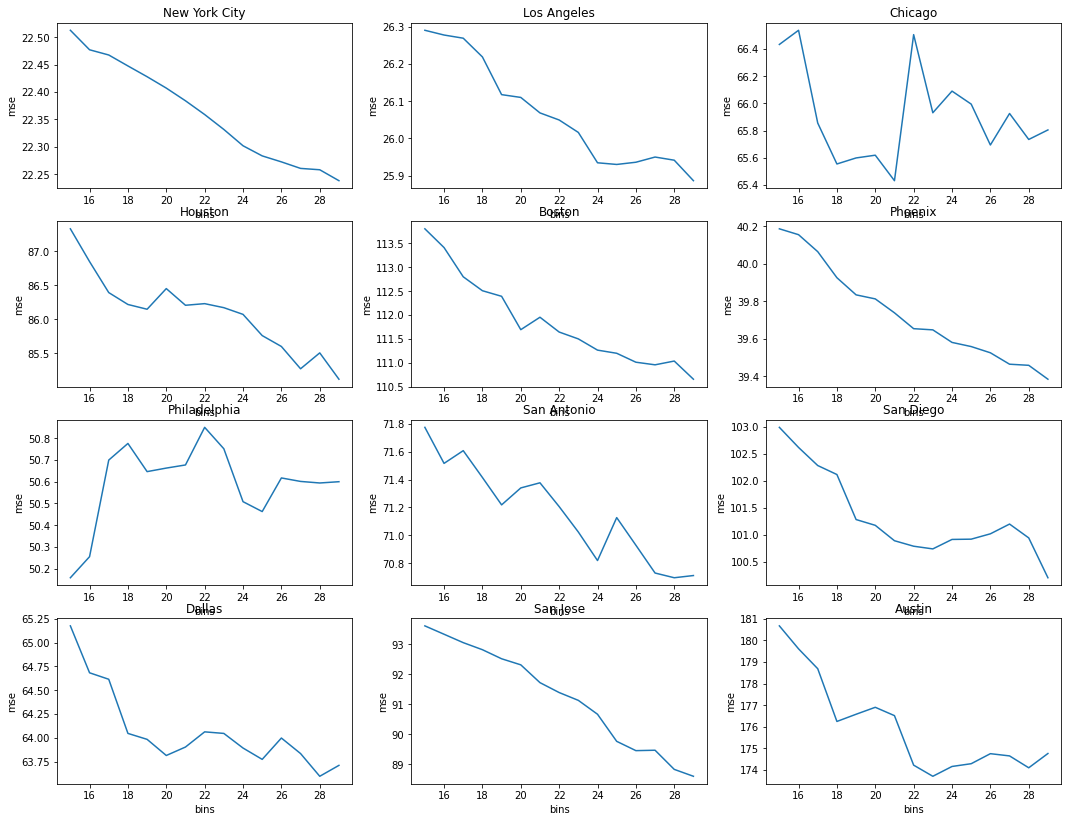

In [117]:
fig = plt.figure(figsize=(18, 14))
for i, j in enumerate(all_mse):
    ax = plt.subplot(4, 3, i+1)
    ax.plot(np.arange(15, 30), all_mse[i])
    
    ax.set_title(cities[i][0])
    ax.set_ylabel('mse')
    ax.set_xlabel('bins')

In [119]:
uv.head()

,from,to,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,distance,S000jobs,S000residence,bin,F,V,m,U,n,pred
0,48453000101,48453000101,64,12,31,21,13,10,41,3,...,0.100000,2578,1594,"(0.099, 2.47]",0.000005,0.000100,10.697987,145.254351,11.990698,25.417390
1,48453001849,48453001754,112,37,69,6,7,21,84,1,...,2.113993,5473,3668,"(0.099, 2.47]",0.000005,0.000100,19.720430,230.851284,25.337963,99.008512
2,48453001819,48453001806,5,2,3,0,0,4,1,2,...,1.197900,705,960,"(0.099, 2.47]",0.000005,0.000100,6.315789,185.408893,4.075145,5.099823
3,48453001849,48453001753,33,19,12,2,3,13,17,2,...,1.847801,2930,3668,"(0.099, 2.47]",0.000005,0.000100,19.720430,159.507886,13.691589,53.500111
4,48453001774,48453001774,46,13,20,13,7,14,25,16,...,0.100000,277,3237,"(0.099, 2.47]",0.000005,83021.791005,16.859375,713.481893,3.112360,10.397183


In [149]:
uv.columns

Index(['from', 'to', 'S000', 'SA01', 'SA02', 'SA03', 'SE01', 'SE02', 'SE03',
       'SI01', 'SI02', 'SI03', 'distance', 'S000jobs', 'S000residence', 'bin',
       'F', 'V', 'm', 'U', 'n', 'pred'],
      dtype='object')

In [13]:
def crossvalidation(df,target,bins):
    df['bin'] = pd.qcut(df['distance'], q=bins)
    df['bin'] = df['bin'].astype(str)
    df.sort_values(by='bin', inplace=True)
    df.rename(columns={'residence':'S000residence', 'jobs':'S000jobs'}, inplace=True)
    df.reset_index(drop=True, inplace=True)
    mseList = []
    skf = StratifiedKFold(n_splits=2)
    X = df[['from', 'to', 'distance', target+'residence',
       target+'jobs', target]].values
    y = df[['bin']].values
    skf.get_n_splits(X,y)
    
    kfold_mses = []
    
    for train_index, test_index in skf.split(X, y):
        
        train, test = df.loc[train_index], df.loc[test_index]
        
        f, uv, mf, mu, mv = constrained_model(train, separate_income=False)
#         all_cityF.append(f)
#         all_cityUV.append(uv)

#         uv['pred'] = uv['F']*uv['m']*uv['n']
#         uv['pred'] = uv['pred']*(uv['S000'].sum()/uv['pred'].sum())
        merged = uv[['F', 'm', 'n', 'bin']].merge(test, on='bin', how='right')
        
        merged['pred'] = merged['F']*merged['m']*merged['n']
        merged['pred'] = merged['pred']*(merged['S000'].sum()/merged['pred'].sum())
        
        kfold_mses.append(mean_squared_error(merged['pred'], merged['S000']))
        
#         bin_to_model = fit_bucketed_power_law(train,target)
#         test = predict_bucketed_power_law(test,target,bin_to_model)
#         mseList += [mean_squared_error(test[target+'flow'],test[target+'pred'])]
#     return np.mean(mseList)
    return np.mean(kfold_mses)

In [11]:
cities[0][0]

'New York City'

In [ ]:
test_mse = []

for i, city in enumerate(allCity_dfs[:5]):
    
    mses = []
    for b in np.arange(15, 30):
        
        mses.append(crossvalidation(city, 'S000', b))
        
    test_mse.append(mses)
    print(cities[i][0])

ipfn converged: convergence_rate not updating or below rate_tolerance


In [79]:
allCity_dfs[0].head()

,from,to,S000flow,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,distance,S000jobs,S000residence,bin
0,36005009800,36005001600,11,4,3,4,4,3,4,0,0,11,1.029180,1018,1871,"(0.099, 3.026]"
1,36047034800,36047058800,3,1,2,0,2,1,0,0,0,3,2.280739,1366,879,"(0.099, 3.026]"
2,36005037400,36005031800,3,0,3,0,0,3,0,0,0,3,1.889633,170,1153,"(0.099, 3.026]"
3,36005015300,36005039100,1,1,0,0,0,1,0,0,0,1,2.262164,805,1419,"(0.099, 3.026]"
4,36047086200,36047099400,2,0,2,0,2,0,0,0,0,2,2.573990,35,1406,"(0.099, 3.026]"


In [80]:
for train_index, test_index in crossvalidation(allCity_dfs[0], 'S000', 10):
    print(train_index, test_index)

[ 32562  32563  32564 ... 976829 976830 976831] [     0      1      2 ... 911707 911708 911709]
[     0      1      2 ... 976829 976830 976831] [ 32562  32563  32564 ... 944268 944269 944270]
[     0      1      2 ... 944268 944269 944270] [ 65124  65125  65126 ... 976829 976830 976831]


Text(0, 0.5, 'F')

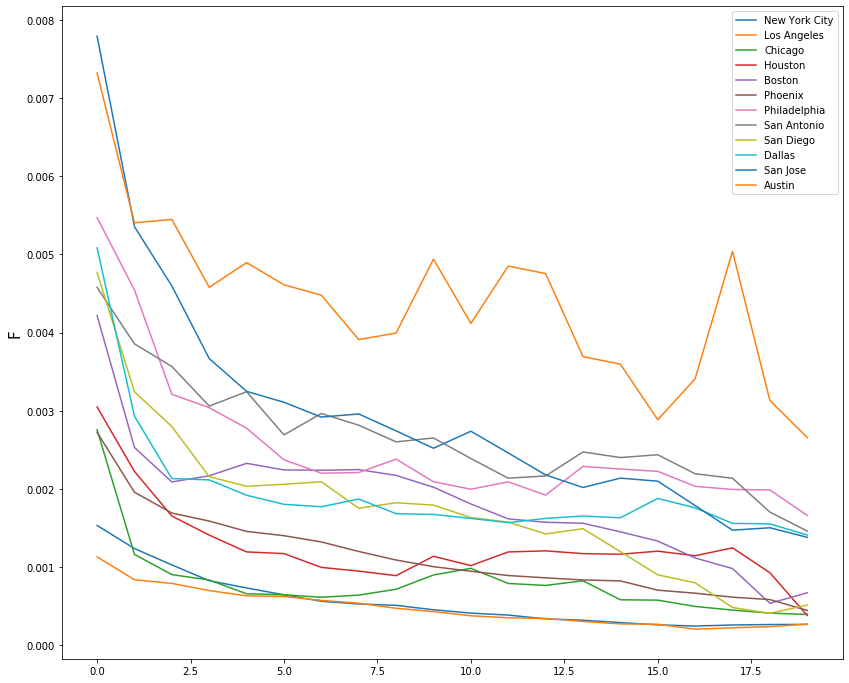

In [9]:
plt.figure(figsize=(14,12))

for i in range(len(all_cityF)):
    plt.plot(all_cityF[i]['F'], label=cities[i][0])
    plt.legend()
plt.ylabel('F', fontsize=15)

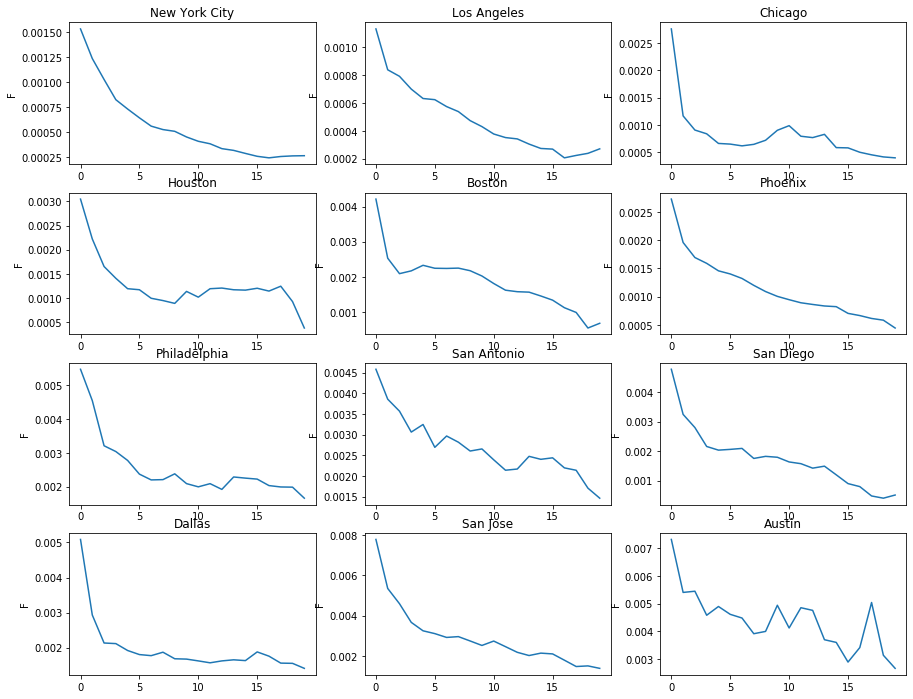

In [10]:
plt.figure(figsize=(15, 12))
for i, j in enumerate(all_cityF):
    ax = plt.subplot(4, 3, i+1)
    ax.plot(all_cityF[i]['F'])
    
    ax.set_title(cities[i][0])
    ax.set_ylabel('F')

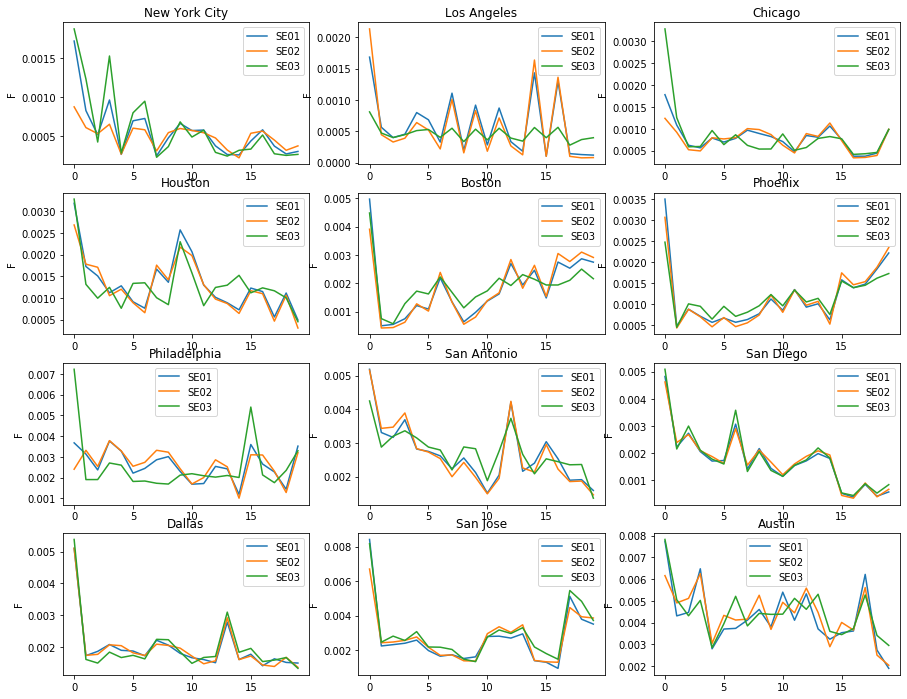

In [13]:
income = ['SE01', 'SE02', 'SE03']

plt.figure(figsize=(15, 12))
for i, j in enumerate(all_cityF):
    ax = plt.subplot(4, 3, i+1)
    
    for k in range(3):
        ax.plot(all_cityF[i][k]['F'], label=income[k])
    
    ax.set_title(cities[i][0])
    ax.set_ylabel('F')
    ax.legend()

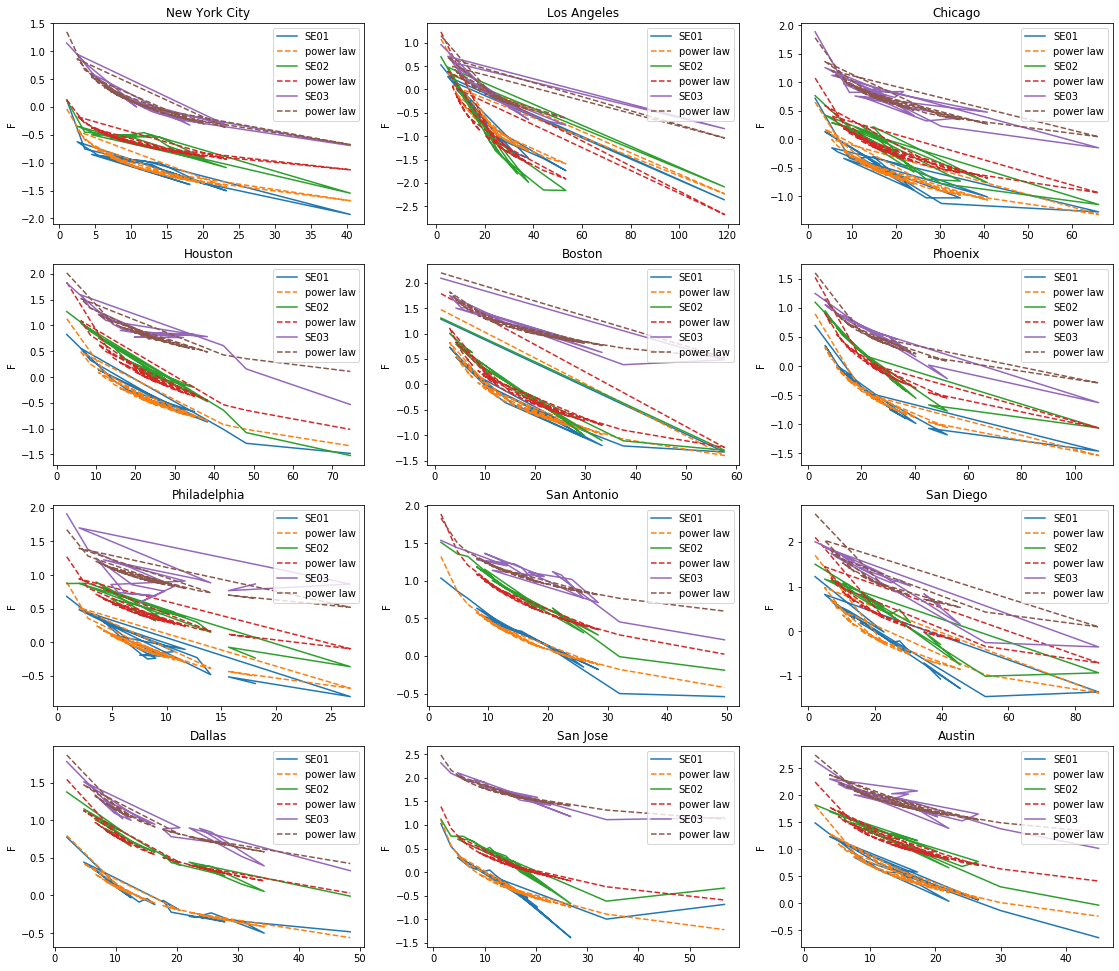

In [32]:
income = ['SE01', 'SE02', 'SE03']

plt.figure(figsize=(19, 17))
for i, j in enumerate(all_cityF):
    ax = plt.subplot(4, 3, i+1)
    
#     temp = all_cityF[i][2]
#     temp['mid'] = [(a.left + a.right)/2 for a in temp.bin]
        
#     y = np.log(temp['F'])
#     X = np.log(temp.mid)
    
#     X = sm.add_constant(X)
#     model = sm.OLS(y,X).fit()
    
    for k in range(3):
        
        temp = all_cityF[i][k]
        temp['mid'] = [(a.left + a.right)/2 for a in temp.bin]
            
        y = np.log(temp['F'])
        X = np.log(temp.mid)
    
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        
        all_cityF[i][k]['mid'] = [(a.left + a.right)/2 for a in all_cityF[i][k].bin]
        
        ax.plot(all_cityF[i][k]['mid'], np.log(all_cityF[i][k]['F']), label=income[k])
        
    
        ax.plot(temp.mid, model.predict(), '--', label='power law')
    ax.set_title(cities[i][0])
    ax.set_ylabel('F')
    ax.legend()

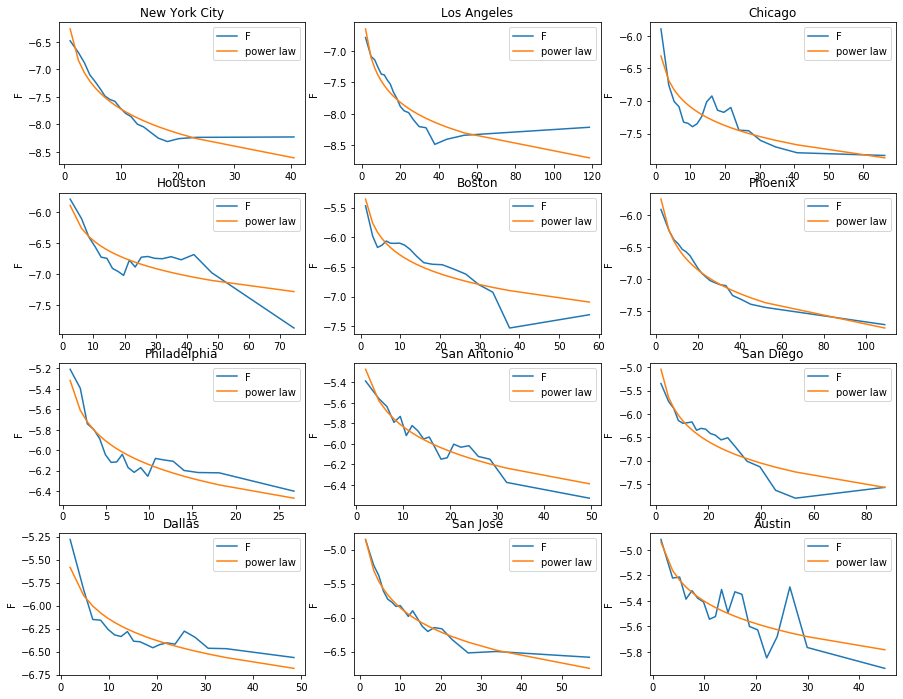

In [11]:
plt.figure(figsize=(15, 12))
for i, j in enumerate(all_cityF):
    ax = plt.subplot(4, 3, i+1)
    
    all_cityF[i]['mid'] = [(a.left + a.right)/2 for a in all_cityF[i].bin]
    y = np.log(all_cityF[i]['F'])
    X = np.log(all_cityF[i].mid)
    
    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()
    
    ax.plot(all_cityF[i].mid, np.log(all_cityF[i]['F']), label='F')
    
    ax.plot(all_cityF[i].mid, model.predict(), label='power law')
    
    ax.set_title(cities[i][0])
    ax.set_ylabel('F')
    ax.legend()

In [ ]:
y_target = ['se01', 'se02', 'se03'] 
origin = df.groupby(['origin']).agg({'se01':sum,'se02':sum,'se03':sum}).reset_index() 
origin.columns = ['origin','se01residence','se02residence','se03residence'] 
destination = df.groupby(['destination']).agg({'se01':sum,'se02':sum,'se03':sum}).reset_index() 
destination.columns = ['destination','se01jobs','se02jobs','se03jobs'] 
data = data.merge(origin,on=['origin']) 
data = data.merge(destination,on=['destination'])

In [2]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
    centroid_all.loc[centroid_all.distance == 0, 'distance'] = 0.2
    
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [3]:
target_columns = ['S000']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('cities/%s.csv'%city,index=False)

NameError: name 'cities' is not defined